<a href="https://colab.research.google.com/github/jgarcia2411/Energy-Supply-Smart-Home/blob/main/ExploratoryDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis - Smart Home Data

**Objective**

The goal of this project is to implement a LSTM neural network to predict the energy demand of a smart home. To do so, we used a time series dataset that contains the energy comsumption of home appliances, energy generation of the home's solar panels, and weather records. In this notebook, we ran a series of data visualization to explore, clean, and arrange the dataset.

In [ ]:
# Libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns 
import time 
from datetime import datetime


# univariate lstm 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Load and take a look at the data

In [ ]:

drive.mount('/data/')#, force_remount= True)
data_dir = '/data/My Drive/EMSE 6575 Final Project/Datasets'
!ls '/data/My Drive/EMSE 6575 Final Project/Datasets'

Mounted at /data/
halfhourly_dataset  HomeC.csv  KAG_energydata_complete.csv  strava_data.csv


Check data structure:
The dataset contains a 1 min resolution measurements and is presented in a tabular data-structure.

In [ ]:
dataset= pd.read_csv(data_dir+'/HomeC.csv')
dataset.sample(3)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
138944,1451763344,1.214233,0.389067,1.214233,0.000033,0.154333,0.064167,0.034783,0.005000,0.006817,0.012800,0.000767,0.000050,0.000017,0.031150,1.166000,0.004183,0.001400,0.389067,41.71,partly-cloudy-night,0.36,10.00,Partly Cloudy,35.18,1009.39,11.51,0.49,353.0,0.0000,16.70,0.00
245234,1451869634,0.430933,0.025000,0.430933,0.000017,0.019767,0.065333,0.052417,0.125233,0.007767,0.012733,0.000500,0.000083,0.000000,0.030250,0.001000,0.004083,0.001467,0.025000,52.80,clear-night,0.89,8.91,Clear,52.80,1021.40,1.08,0,272.0,0.0000,49.67,0.00
85605,1451710005,1.024133,0.017367,1.024133,0.000000,0.052217,0.103867,0.040900,0.135183,0.006633,0.012267,0.000433,0.000000,0.000017,0.031283,0.001017,0.004200,0.001583,0.017367,35.64,partly-cloudy-day,0.63,9.42,Partly Cloudy,25.17,1003.14,18.47,0.31,306.0,0.0012,24.35,0.02


We can see that this dataset has 2 columns that might be the same measurement: 
Hose overall [kW] - use [kW]; gen [kW] - solar [kW]. Later, we will visualize their distribution and see if the are the same

In [ ]:
# Basic statistics of numeric measurements
dataset.describe()

,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
count,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000
mean,0.858962,0.076229,0.858962,0.031368,0.099210,0.136779,0.081287,0.063556,0.042137,0.014139,0.002755,0.007023,0.000009,0.058530,0.015642,0.010983,0.035313,0.076229,50.741935,0.664085,9.253444,48.263382,1016.301625,6.649936,202.356843,0.002598,38.694013,0.056453
std,1.058207,0.128428,1.058207,0.190951,0.169059,0.178631,0.104466,0.076199,0.057967,0.014292,0.021860,0.076740,0.000010,0.202706,0.137841,0.098859,0.096056,0.128428,19.113807,0.194389,1.611186,22.027916,7.895185,3.982716,106.520474,0.011257,19.087939,0.165836
min,0.000000,0.000000,0.000000,0.000000,0.000017,0.000067,0.000083,0.000067,0.000017,0.000017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-12.640000,0.130000,0.270000,-32.080000,986.400000,0.000000,0.000000,0.000000,-27.240000,0.000000
25%,0.367667,0.003367,0.367667,0.000000,0.020233,0.064400,0.040383,0.005083,0.007133,0.012733,0.000500,0.000017,0.000000,0.029833,0.000983,0.003617,0.001483,0.003367,35.770000,0.510000,9.420000,31.090000,1011.290000,3.660000,148.000000,0.000000,24.600000,0.000000
50%,0.562333,0.004283,0.562333,0.000017,0.020617,0.066633,0.042217,0.005433,0.008083,0.012933,0.000667,0.000050,0.000017,0.031317,0.001000,0.004000,0.001617,0.004283,50.320000,0.680000,10.000000,50.320000,1016.530000,5.930000,208.000000,0.000000,39.030000,0.000000
75%,0.970250,0.083917,0.970250,0.000233,0.068733,0.080633,0.068283,0.125417,0.053192,0.013100,0.000750,0.000167,0.000017,0.032883,0.001017,0.004067,0.001750,0.083917,66.260000,0.840000,10.000000,66.260000,1021.480000,8.940000,295.000000,0.000000,54.790000,0.000000
max,14.714567,0.613883,14.714567,1.401767,1.934083,0.794933,0.971750,0.851267,1.273933,1.088983,1.166583,2.262583,0.000183,7.027900,1.633017,1.929800,0.465217,0.613883,93.720000,0.980000,10.000000,101.120000,1042.460000,22.910000,359.000000,0.191000,75.490000,0.840000


Taking a quick look at the data, it seems like we might have some outliers. For example, for use [kW] we see that the 75% percentile is at 0.97, while the maximum value is at 14.71. A similar story can be seen for most of the 'usage' columns, the maximum value is quite larger than the value at the 75% percentile mark. Also, the scales are quite different, for example comparing some of the weather columns (humidity and pressure).

Let's get a better look at column info:

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503911 entries, 0 to 503910
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   time                 503911 non-null  object 
 1   use [kW]             503910 non-null  float64
 2   gen [kW]             503910 non-null  float64
 3   House overall [kW]   503910 non-null  float64
 4   Dishwasher [kW]      503910 non-null  float64
 5   Furnace 1 [kW]       503910 non-null  float64
 6   Furnace 2 [kW]       503910 non-null  float64
 7   Home office [kW]     503910 non-null  float64
 8   Fridge [kW]          503910 non-null  float64
 9   Wine cellar [kW]     503910 non-null  float64
 10  Garage door [kW]     503910 non-null  float64
 11  Kitchen 12 [kW]      503910 non-null  float64
 12  Kitchen 14 [kW]      503910 non-null  float64
 13  Kitchen 38 [kW]      503910 non-null  float64
 14  Barn [kW]            503910 non-null  float64
 15  Well [kW]        

It seems that one row contains null-type data, let's take a better look:

In [ ]:
dataset.isnull().sum().to_dict()

{'Barn [kW]': 1,
 'Dishwasher [kW]': 1,
 'Fridge [kW]': 1,
 'Furnace 1 [kW]': 1,
 'Furnace 2 [kW]': 1,
 'Garage door [kW]': 1,
 'Home office [kW]': 1,
 'House overall [kW]': 1,
 'Kitchen 12 [kW]': 1,
 'Kitchen 14 [kW]': 1,
 'Kitchen 38 [kW]': 1,
 'Living room [kW]': 1,
 'Microwave [kW]': 1,
 'Solar [kW]': 1,
 'Well [kW]': 1,
 'Wine cellar [kW]': 1,
 'apparentTemperature': 1,
 'cloudCover': 1,
 'dewPoint': 1,
 'gen [kW]': 1,
 'humidity': 1,
 'icon': 1,
 'precipIntensity': 1,
 'precipProbability': 1,
 'pressure': 1,
 'summary': 1,
 'temperature': 1,
 'time': 0,
 'use [kW]': 1,
 'visibility': 1,
 'windBearing': 1,
 'windSpeed': 1}

In [ ]:
## Let's drop that row with NaN values in the dataset
dataset.dropna(inplace=True)

When looking at the data types, we can see that the dataset contains some categorical columns:
icon, summary, and cloudCover. Let's see what these columns contain:

In [ ]:
print('The values contained in icon column: \n', dataset.icon.value_counts().to_dict(), '\n')
print('The values contained in summary column: \n', dataset.summary.value_counts().to_dict(), '\n')
print('The values contained in cloudCover column: \n', dataset.cloudCover.value_counts().to_dict(), '\n')

The values contained in icon column: 
 {'clear-night': 194536, 'clear-day': 182252, 'rain': 43081, 'partly-cloudy-day': 39492, 'partly-cloudy-night': 27324, 'snow': 7550, 'cloudy': 6041, 'wind': 2660, 'fog': 974} 

The values contained in summary column: 
 {'Clear': 376730, 'Partly Cloudy': 62268, 'Light Rain': 27368, 'Drizzle': 10370, 'Overcast': 6041, 'Rain': 5169, 'Mostly Cloudy': 4548, 'Light Snow': 4323, 'Flurries': 1789, 'Breezy': 1561, 'Snow': 1152, 'Breezy and Partly Cloudy': 1041, 'Foggy': 974, 'Rain and Breezy': 174, 'Heavy Snow': 171, 'Flurries and Breezy': 115, 'Breezy and Mostly Cloudy': 58, 'Dry': 58} 

The values contained in cloudCover column: 
 {0.0: 63596, 0.31: 48101, 1.0: 47255, 0.03: 33186, 0.04: 23711, 0.07: 17995, 0.08: 17183, 0.05: 17146, 0.06: 13645, 0.09: 13491, 0.1: 12133, 0.12: 11385, 0.11: 11210, 0.13: 11096, 0.02: 9708, 0.15: 8968, 0.16: 8280, 0.17: 8001, 0.14: 7939, 0.01: 7767, 0.19: 7637, 0.18: 7542, 0.21: 7294, 0.23: 6791, 0.2: 6781, 0.24: 6760, 0.22: 6

Most of the values in cloudCover column seem to refer to %, but some values equal "cloudCover", so we replace these values with the expected value of cloudCover. 

0.22588514087450015


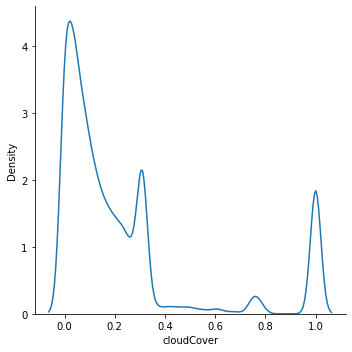

In [ ]:
## filter the 'cloudCover' values and create a series with the values
cloudcover = dataset[dataset['cloudCover']!='cloudCover'].reset_index()
values = cloudcover['cloudCover'].astype(float)
sns.displot(values, kind='kde')
print(values.mean())

0.22 looks not a good value to take because the distribution seems most values tend to be close to 0.
Let's consider 0.22 for now and then see what happens in training if we change this value later on.

Now, lets replace cloudCover with 0.22, and then transform the type to float:

In [ ]:
dataset['cloudCover'] = dataset['cloudCover'].replace(['cloudCover'],'0.22')
## Cloud cover is described as a string, and seems it indicates the % of sky is cover:
dataset['cloudCover'] = dataset['cloudCover'].astype(float)
# icon and summary lets transform into category
dataset['icon'] = dataset['icon'].astype('category')
dataset['summary'] = dataset['summary'].astype('category') 

# **Data Visualization**

- Create visualization of time series and the different measurements
- Create visualization of the distribution of the weather parameters
- Detect if some columns contain same values (use, and generation)

In [ ]:
# A sample of 1000 measurements out of 500K, so we don't crash Colab
dataset_sample= dataset.sample(n=1000, random_state=1234)

Let's start by making line plots, showing the different values on the y-axis and time on the x-axis.

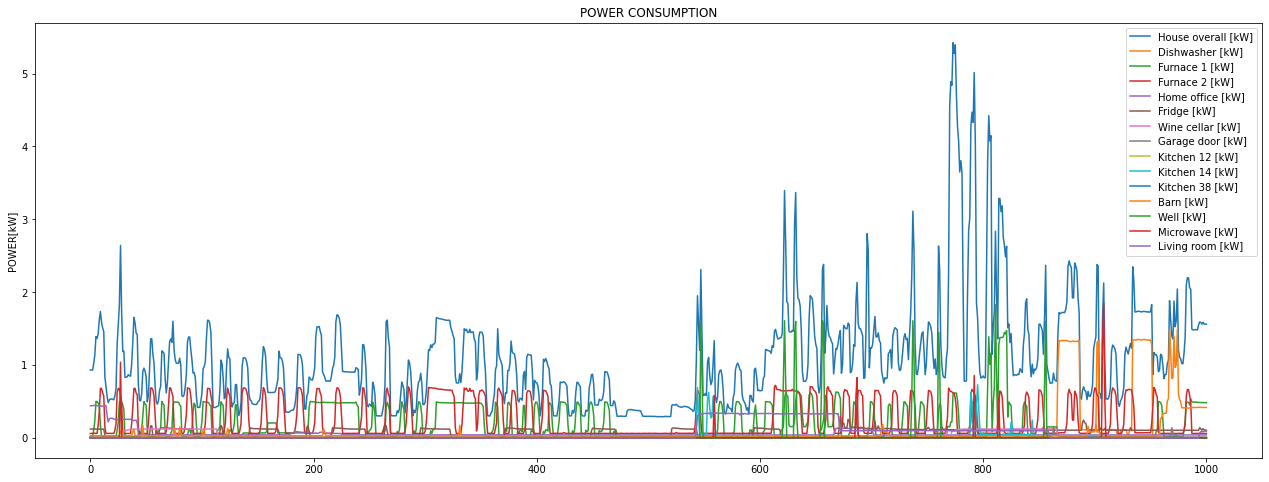

In [ ]:
# time plot of the different power-usage attributes (we're most interested in the house overall)
fig, ax= plt.subplots(figsize= (22,8))
for i in ['House overall [kW]', 'Dishwasher [kW]',
       'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]',
       'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
       'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
       'Microwave [kW]', 'Living room [kW]']:
       sns.lineplot(x=dataset.iloc[0:1001].index,y= dataset.loc[:1000,i], ax=ax)
ax.legend(['House overall [kW]', 'Dishwasher [kW]',
       'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]',
       'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
       'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
       'Microwave [kW]', 'Living room [kW]'])
ax.set_title('POWER CONSUMPTION')
plt.ylabel('POWER[kW]')
plt.show()

Now, let's compare the power generation and power usage on a timeplot:

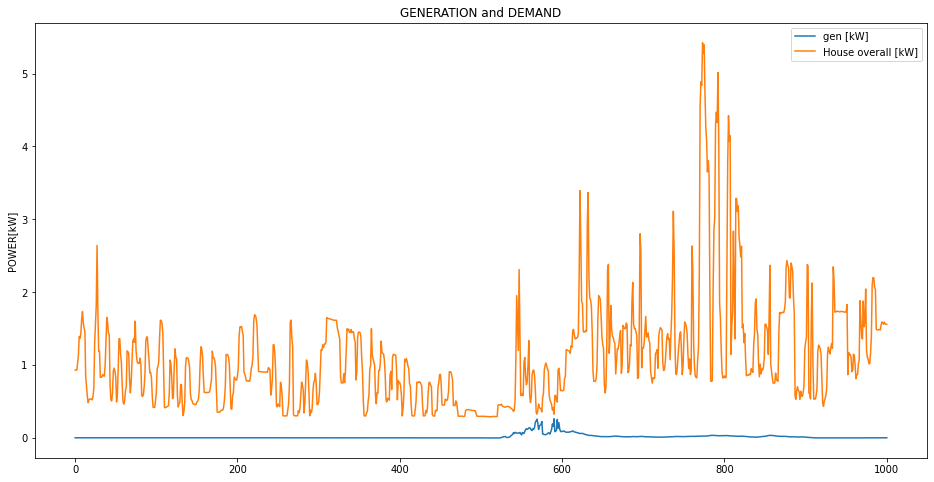

In [ ]:
fig, ax= plt.subplots(figsize= (16,8))
for i in ['gen [kW]', 'House overall [kW]']:
       sns.lineplot(x=dataset.iloc[0:1001].index,y= dataset.loc[:1000,i], ax=ax)
ax.legend(['gen [kW]', 'House overall [kW]'])
ax.set_title('GENERATION and DEMAND')
plt.ylabel('POWER[kW]')
plt.show()

We can see that the generated power is almost negligible in comparison with the usage.

We created a pairplot to visualize the distribution of weather parameters and their correlation with energy compumption and between each other.

We can see that some features seem to be heavily correlated, while others seem to have little to no correlation at all.

Seemingly correlated features are for example, temperature & apparentTemperature, temperature & dewPoint, precipIntensity & precProbability, and humidity & visibility.

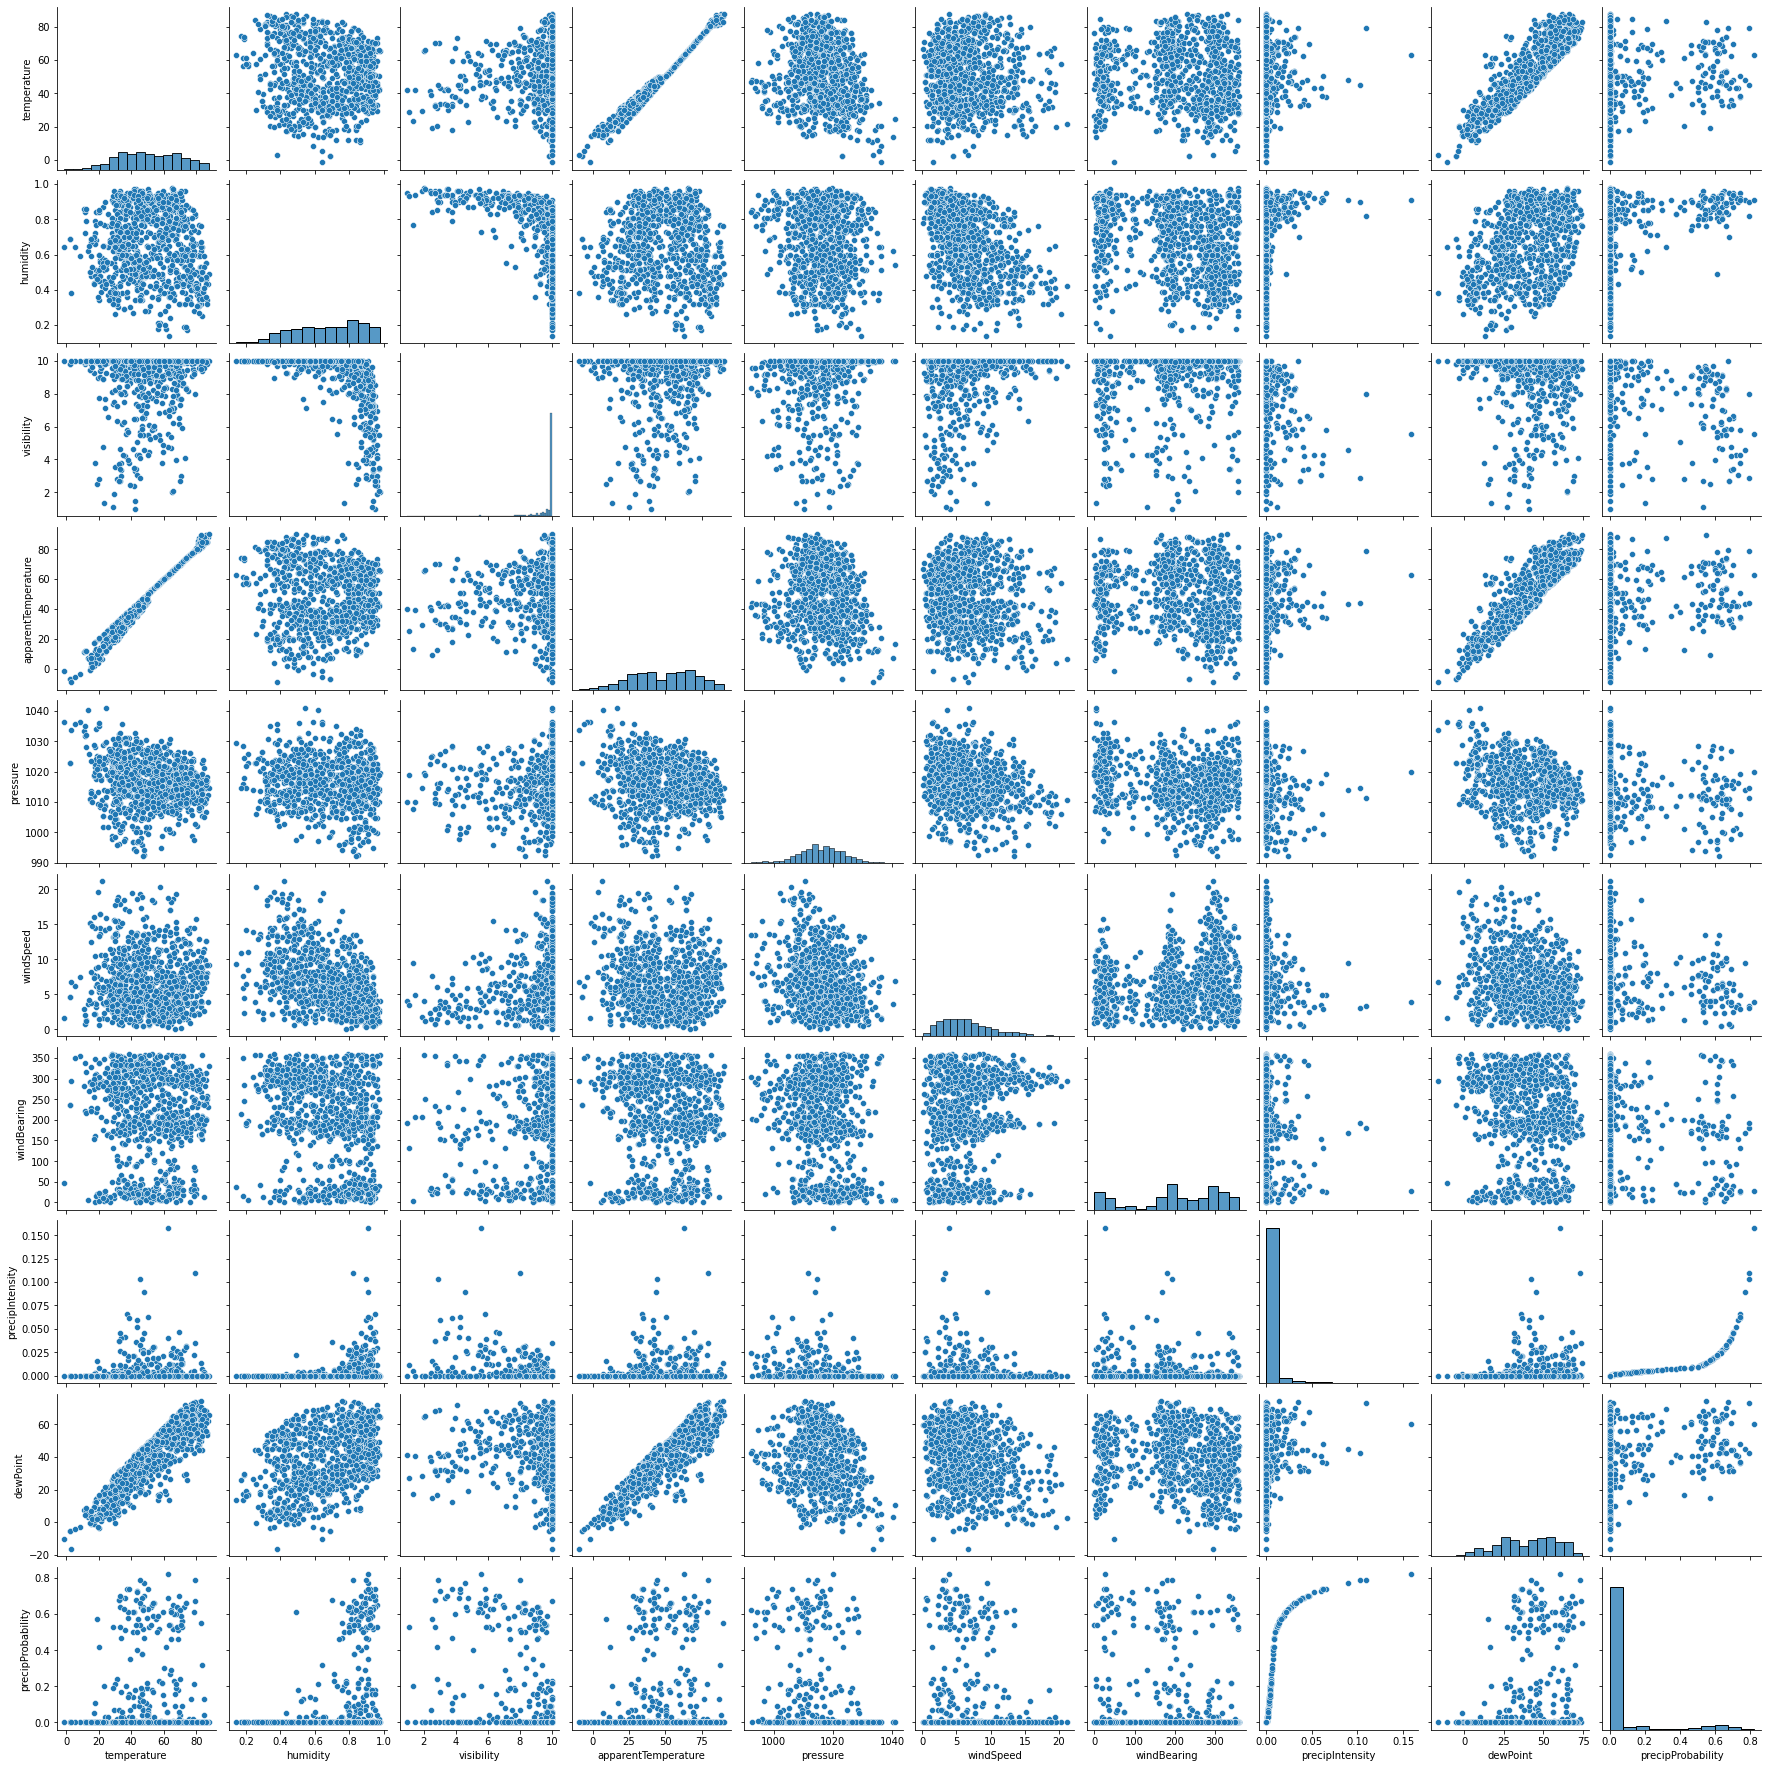

In [ ]:
# Plot the distribution of weather parameters
sns.pairplot(dataset_sample[['temperature','humidity', 'visibility', 
                             'apparentTemperature', 'pressure', 'windSpeed', 
                             'windBearing', 'precipIntensity', 'dewPoint', 
                             'precipProbability']])

Another, perhaps more convenient way, to look at the different correlations is to plot a heat map:

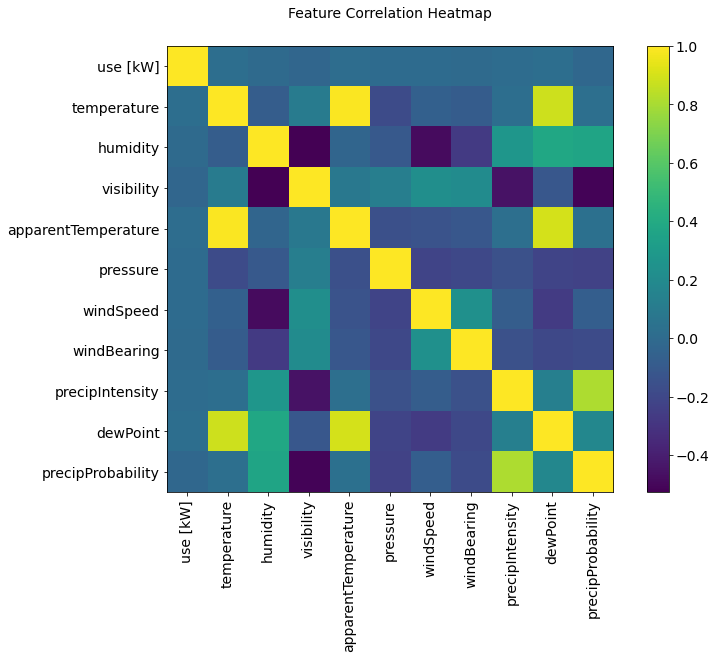

In [ ]:

features = dataset_sample[['use [kW]','temperature','humidity', 'visibility', 
                             'apparentTemperature', 'pressure', 'windSpeed', 
                             'windBearing', 'precipIntensity', 'dewPoint', 
                             'precipProbability']]

plt.figure(figsize=(12,8))
plt.matshow(features.corr(), fignum=1)
plt.xticks(range(features.shape[1]), features.columns, fontsize=14,rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(features.shape[1]), features.columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

By playing with rearranging the features, we can see more clearly that some of them seem to be redundant:

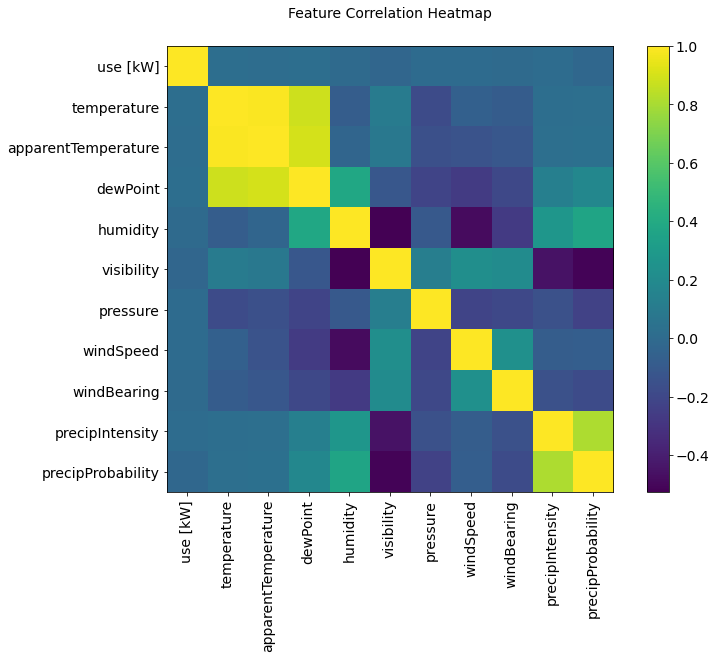

In [ ]:
features = dataset_sample[['use [kW]','temperature','apparentTemperature','dewPoint',
                           'humidity', 'visibility',
                           'pressure', 'windSpeed',
                           'windBearing', 'precipIntensity',
                           'precipProbability']]

plt.figure(figsize=(12,8))
plt.matshow(features.corr(), fignum=1)
plt.xticks(range(features.shape[1]), features.columns, fontsize=14,rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(features.shape[1]), features.columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

We can therefore skip some of the features, and only select ones that provide insight:


*   Use: temperature, humidity, visibility, pressure, windSpeed, windBearing, precipProbability
*   Skip: apparentTemperature, dewPoint, precipIntensity



In [ ]:
use_features = ['temperature', 'humidity', 'visibility', 'pressure', 'windSpeed', 'windBearing', 'precipProbability']

Observations from visualizations: 

- The power generation of this home is not even close to the demand.
- House overall [kW] - use [kW]; gen [kW] - solar [kW] are the same measurement, so we will consider this in data cleaning.
- Some of the features seemed redundant, so we could remove them

## **Data Prepreparation**

This step involves formating time column into datetime format, framing time series dataset to a supervised learning problem, normalizing the input variables.
We will frame the supervised learning problem as predicting the power demand at the current hour (t) given the power demand measurement and weather conditions at the prior time step.



Time column into datetime transformation:

In [ ]:
# We can create a our own index and then set that index to dataset: taken from kaggle
time_index = pd.date_range('2016-01-01 05:00', periods=len(dataset),  freq='min')  
time_index = pd.DatetimeIndex(time_index)
dataset = dataset.set_index(time_index)

## We can resample our dataset to a 60min resolution timeseries:
re_dataset = dataset.resample(rule='60min').mean()

# The last line of code only worked for numerical values, therefore we work separately for categorical variables:
categoricals_re = dataset[['icon','summary']]

# Then we concat both datsets with an inner join concat method. 
re_dataset = pd.concat([re_dataset, categoricals_re], axis=1, join='inner')

# Get rid of redundant columns: House overall [kw], solar [kw]
re_dataset = re_dataset.drop(['House overall [kW]', 'Solar [kW]'], axis =1)

# Agregating in one variable the different kitchen columns, and furnance columns:
re_dataset['Kitchen [kW]']= re_dataset['Kitchen 12 [kW]']  + re_dataset['Kitchen 14 [kW]'] + re_dataset['Kitchen 38 [kW]']
re_dataset['Furnance [kW]'] = re_dataset['Furnace 1 [kW]'] + re_dataset['Furnace 2 [kW]']
re_dataset = re_dataset.drop(['Kitchen 12 [kW]', 'Kitchen 14 [kW]', 'Kitchen 38 [kW]'], axis =1)
re_dataset = re_dataset.drop(['Furnace 1 [kW]', 'Furnace 2 [kW]'], axis =1)

# Reorganizing columns with our features at the begining and target at the end
re_dataset = re_dataset[['temperature', 'humidity', 'visibility',
       'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipProbability',
       'icon', 'summary', 'gen [kW]', 'Dishwasher [kW]', 'Furnance [kW]',
       'Home office [kW]', 'Fridge [kW]', 'Wine cellar [kW]',
       'Garage door [kW]', 'Barn [kW]', 'Well [kW]', 'Microwave [kW]',
       'Living room [kW]', 'Kitchen [kW]', 'use [kW]']]

# For convenience lets get rid of the [kW] that is known:
re_dataset.columns = ['temperature', 'humidity', 'visibility',
        'pressure', 'wind_speed', 'cloud_cover',
       'wind_bearing', 'precip_probability',
       'weather_like', 'sky_like', 'power_generation', 'dishwasher', 'furnance',
       'home_office', 'fridge', 'wine_cellar','garage_door', 'barn', 'well', 
       'microwave','living_room', 'kitchen', 'power_demand']


In [ ]:
re_dataset.columns
re_dataset.to_csv('/data/My Drive/EMSE 6575 Final Project/re_sampled.csv')

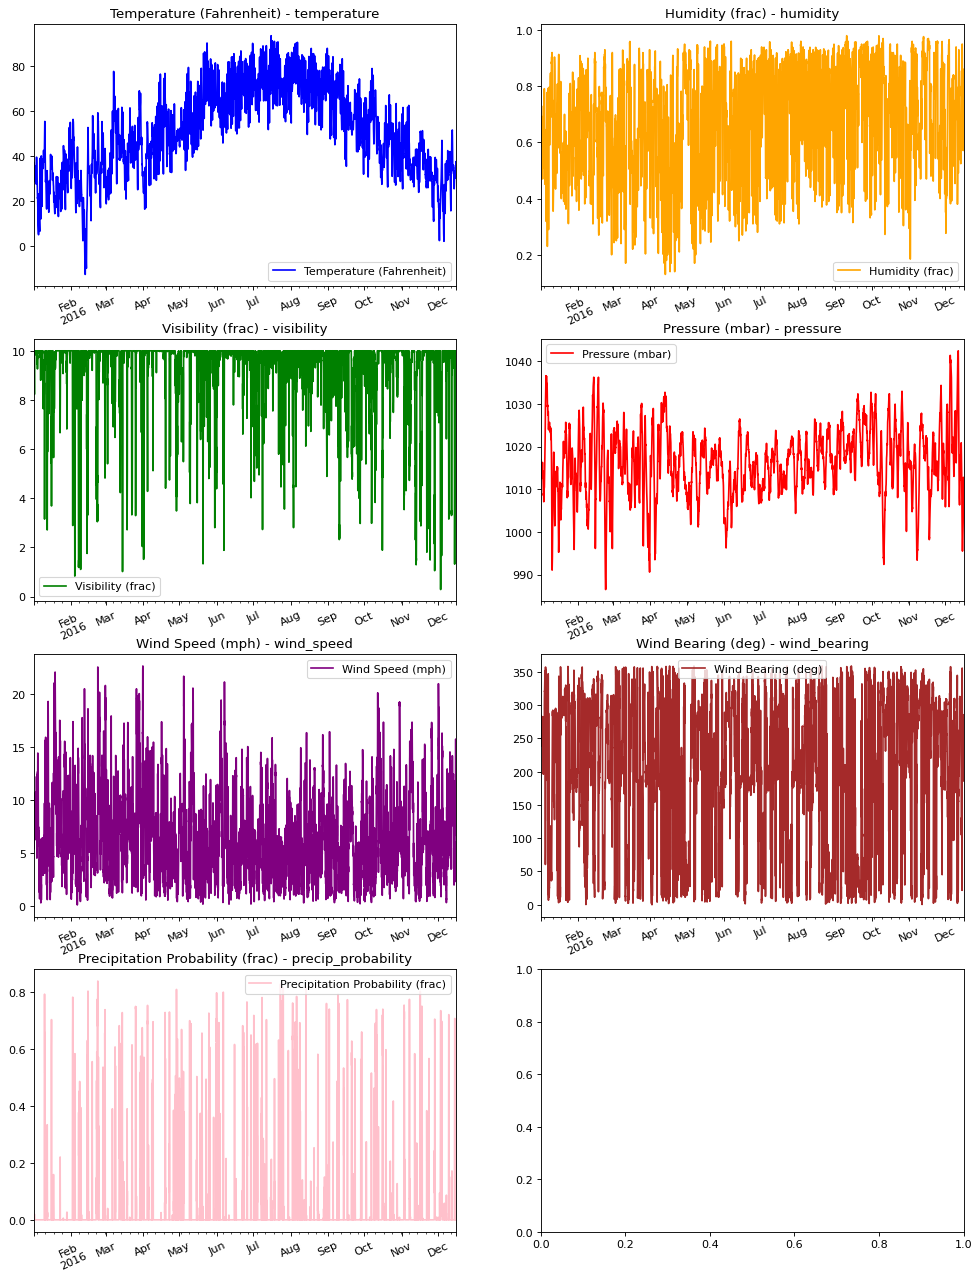

In [ ]:
titles = [
    "Temperature (Fahrenheit)",
    "Humidity (frac)",
    "Visibility (frac)",
    "Pressure (mbar)",
    "Wind Speed (mph)",
    'Wind Bearing (deg)',
    "Precipitation Probability (frac)" ]

feature_keys = [
                'temperature',
                'humidity',
                'visibility',
                'pressure',
                'wind_speed',
                'wind_bearing',
                'precip_probability']
colors = [
          "blue",
          "orange",
          "green",
          "red",
          "purple",
          "brown",
          "pink"
          ]



def create_visualization(dataset):
  fig, axes = plt.subplots(
      nrows= 4, ncols=2, figsize=(15,20), dpi=80, facecolor='w', edgecolor='k'
  )
  for i in range(len(feature_keys)):
    key = feature_keys[i]
    c = colors[i % (len(colors))]
    data = dataset[key]
    ax = data.plot(ax = axes[i // 2, i % 2], 
                   color=c, 
                   title ="{} - {}".format(titles[i], key), 
                   rot=25)
    ax.legend([titles[i]])
  

create_visualization(re_dataset)


Convert time series dataframe to a supervised learning dataframe
In this step we also can encode categorical variables into integer encode. Later we could try to use one-hot encode as feature engineering step.

In [ ]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  """
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
  
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
   cols.append(df.shift(i))
   names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
   # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
	# drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg
  

Normalizing the data:

In [ ]:
# This code is me trying to follow the code in the webpage I am following:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

values = re_dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,8] = encoder.fit_transform(values[:,8])
values[:,9] = encoder.fit_transform(values[:,9])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[range(23,45)]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var22(t-1)  var23(t-1)  var23(t)
1   0.459221   0.576078        1.0  ...    0.003092    0.108914  0.095765
2   0.456466   0.564706        1.0  ...    0.002821    0.095765  0.074528
3   0.452190   0.568235        1.0  ...    0.002737    0.074528  0.100133
4   0.451219   0.600000        1.0  ...    0.003035    0.100133  0.066710
5   0.452818   0.601961        1.0  ...    0.002999    0.066710  0.127212

[5 rows x 24 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [ ]:
reframed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8398 entries, 1 to 8398
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   var1(t-1)   8398 non-null   float32
 1   var2(t-1)   8398 non-null   float32
 2   var3(t-1)   8398 non-null   float32
 3   var4(t-1)   8398 non-null   float32
 4   var5(t-1)   8398 non-null   float32
 5   var6(t-1)   8398 non-null   float32
 6   var7(t-1)   8398 non-null   float32
 7   var8(t-1)   8398 non-null   float32
 8   var9(t-1)   8398 non-null   float32
 9   var10(t-1)  8398 non-null   float32
 10  var11(t-1)  8398 non-null   float32
 11  var12(t-1)  8398 non-null   float32
 12  var13(t-1)  8398 non-null   float32
 13  var14(t-1)  8398 non-null   float32
 14  var15(t-1)  8398 non-null   float32
 15  var16(t-1)  8398 non-null   float32
 16  var17(t-1)  8398 non-null   float32
 17  var18(t-1)  8398 non-null   float32
 18  var19(t-1)  8398 non-null   float32
 19  var20(t-1)  8398 non-null  

## Model formulation

Define and Fit Model
First, we split the dataset into train and test sets. We will see how fast this model works and decide if we would need more computation capacity

In [ ]:
# split into train and test sets
values = reframed.values
# our dataset contains 350 days in one hour resolution
# lets train with 70% of that data: 5897 hours
n_train_hours = 5879
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]: this is required for the LSTM model :/
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5879, 1, 23) (5879,) (2519, 1, 23) (2519,)


Now we define a model with 50 neurones in the first hidden layer and 1 neuron in the output layer for prediction power_demand. The input shape will be 1 time step with 25 features. We will use (MAE) as the loss function and the Adam gradient descent. This model witll be fit for 50 traning epochs with a batch size of 72.. 

Epoch 1/100
164/164 - 2s - loss: 0.0392 - val_loss: 0.0277
Epoch 2/100
164/164 - 0s - loss: 0.0348 - val_loss: 0.0306
Epoch 3/100
164/164 - 0s - loss: 0.0333 - val_loss: 0.0294
Epoch 4/100
164/164 - 0s - loss: 0.0319 - val_loss: 0.0292
Epoch 5/100
164/164 - 0s - loss: 0.0311 - val_loss: 0.0282
Epoch 6/100
164/164 - 0s - loss: 0.0306 - val_loss: 0.0279
Epoch 7/100
164/164 - 0s - loss: 0.0302 - val_loss: 0.0252
Epoch 8/100
164/164 - 0s - loss: 0.0302 - val_loss: 0.0288
Epoch 9/100
164/164 - 0s - loss: 0.0300 - val_loss: 0.0260
Epoch 10/100
164/164 - 0s - loss: 0.0299 - val_loss: 0.0278
Epoch 11/100
164/164 - 0s - loss: 0.0299 - val_loss: 0.0292
Epoch 12/100
164/164 - 0s - loss: 0.0298 - val_loss: 0.0262
Epoch 13/100
164/164 - 0s - loss: 0.0295 - val_loss: 0.0273
Epoch 14/100
164/164 - 0s - loss: 0.0297 - val_loss: 0.0291
Epoch 15/100
164/164 - 0s - loss: 0.0297 - val_loss: 0.0284
Epoch 16/100
164/164 - 0s - loss: 0.0294 - val_loss: 0.0270
Epoch 17/100
164/164 - 0s - loss: 0.0294 - val_lo

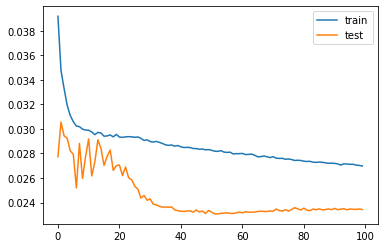

In [ ]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=36, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Model Evaluation:
Will make prediction and evaluate the RMSE:

In [ ]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 4.199


In [ ]:
test_X.shape

(2519, 23)

We can try to better the results by using: https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/


We can see on the lineplot above that the loss for the training set keeps lowering with increasing epochs, but the test loss drops in the beginning and then is unstable with an increased number of epochs.

We can also see that the loss seems to slow as the epochs increase (though still lowering). This tells us that increasing the epochs might not be that helpful.

However, it's worth checking what happends if we increase the epochs - let's start by increasing them to 100 and see what happens.